# Feature Extraction: SIFT

## Setup

In [142]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [143]:
sns.set_style('darkgrid')

In [3]:
#paths
root = '.'
data_folder = f'{root}/data'
feature_data_folder = f'{root}/data'

## Load Data

In [ ]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns: 
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [9]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

In [10]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8960, 227, 227, 3)
Shape of labels: (8960,)


## View Class Samples

In [ ]:
def plot_class_samples(images: list, labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,3))

    for i, (label, image) in enumerate(zip(labels, images)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('One Image For Each Class')
    plt.show()

def load_class_samples(images: list, labels: list) -> tuple:
    label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
    unique_labels = np.unique(labels)

    sample_images = []
    sample_labels = []

    for value in unique_labels:
        label = label_names[value - 1]
        index = int(np.where(train_labels==value)[0][0])

        sample_labels.append(label)
        sample_images.append(images[index])
    
    return sample_images, sample_labels

In [19]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

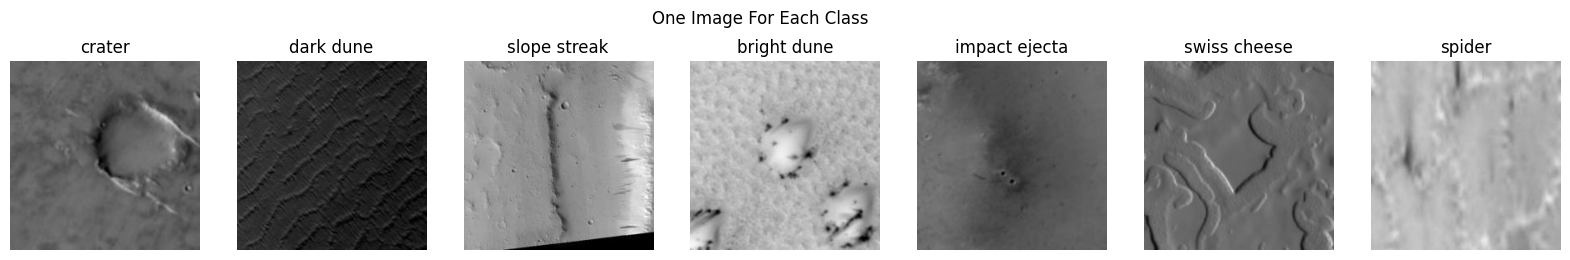

In [21]:
plot_class_samples(sample_imgs, sample_lbls)

## Feature Extraction: SIFT

In [176]:
def get_sift_feature(imgs: list) -> tuple:
    nfeats = 25
    sift = cv2.SIFT_create(nfeatures=nfeats)
    sift_kp = []
    sift_ar = []

    for img in imgs:
        kp, des = sift.detectAndCompute(img, None)

        if len(kp) > nfeats:
            kp = kp[:nfeats]
            des = des[:nfeats]

        if des is None:
            des = np.zeros((nfeats, 128))
        elif len(kp) < nfeats:
            des = np.pad(des, ((0, nfeats - len(kp)), (0, 0)), mode='constant')

        sift_kp.append(kp)
        sift_ar.append(des.ravel())

    return sift_kp, np.array(sift_ar)

def extract_SIFT(img_dataset):
    """ 
    Apply HOG feature extraction to all training images 
    args: img_dataset (training / testing dataset)

    returns: train_images_hog (dataset of hog features)
    """
    img_dataset_SIFT = []
    sift = cv.SIFT_create()
    for img in img_dataset:
        keypoints, keypoints_arr = sift.detectAndCompute(image, None)
        
        img_dataset_SIFT.append(keypoints_arr.ravel())
    
    img_dataset_SIFT = np.array(img_dataset_SIFT) 
    return img_dataset_SIFT

def plot_keypoint_samples(sample_kp: list, sample_imgs: list, sample_labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(sample_kp), figsize=(20,3))

    samples = zip(sample_labels, sample_imgs, sample_kp)

    for i, (label, img, kp) in enumerate(samples):
        ax = axs[i]

        #ax.hist(sample.ravel(), 256, [0,256])
        sift_image = cv2.drawKeypoints(
            img, kp, 0, (0, 0, 255), #blue color circles 
            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

        ax.imshow(sift_image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('SIFT Features per Class')
    plt.show()

### View Sift Sample

In [177]:
sample_kp, sample_sift = get_sift_feature(sample_imgs)

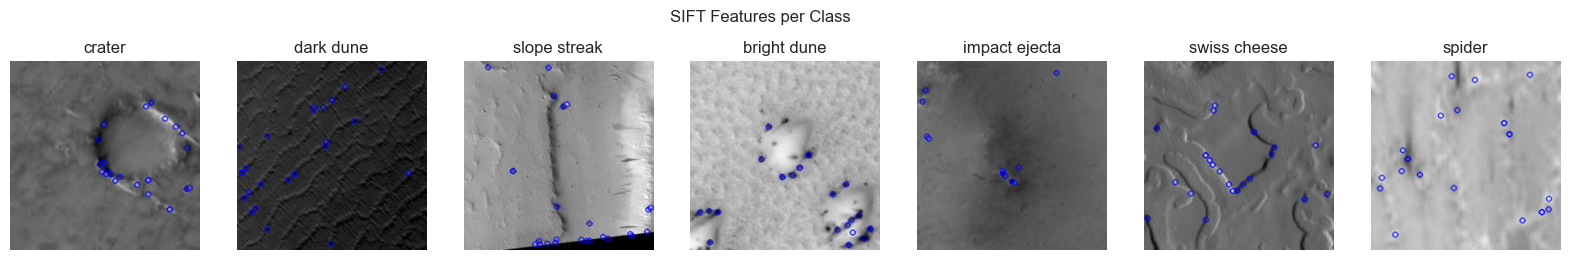

In [178]:
plot_keypoint_samples(sample_kp, sample_imgs, sample_lbls)

In [179]:
_, train_sift = get_sift_feature(train_images)
_, val_sift = get_sift_feature(val_images)
_, test_sift = get_sift_feature(test_images)

In [195]:
np.save(f'{feature_data_folder}/train_sift.npy', train_sift)
np.save(f'{feature_data_folder}/val_sift.npy', val_sift)
np.save(f'{feature_data_folder}/test_sift.npy', test_sift)

## PCA

In [180]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_sift)

In [181]:
pca = PCA()
pca.fit(X_scaled)

PCA()

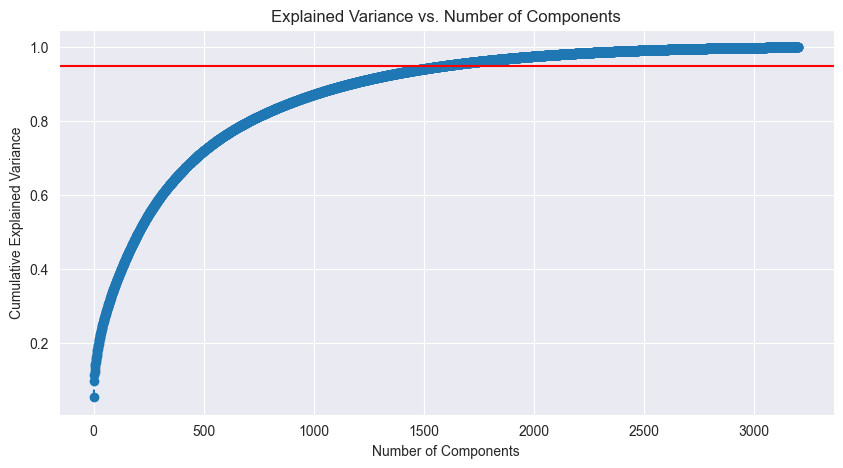

In [183]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
# draw a line at 90% of explained variance
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

## PCA down to 1500, $\approx 95\%$

In [184]:
pca = PCA(n_components=1500)
pca.fit(X_scaled)

PCA(n_components=1500)

In [185]:
train_sift = pca.transform(scaler.transform(train_sift))
val_sift = pca.transform(scaler.transform(val_sift))
test_sift = pca.transform(scaler.transform(test_sift))

In [125]:
np.save(f'{feature_data_folder}/train_sift.npy', train_sift)
np.save(f'{feature_data_folder}/val_sift.npy', val_sift)
np.save(f'{feature_data_folder}/test_sift.npy', test_sift)

### View Clusters

In [186]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(X_scaled)

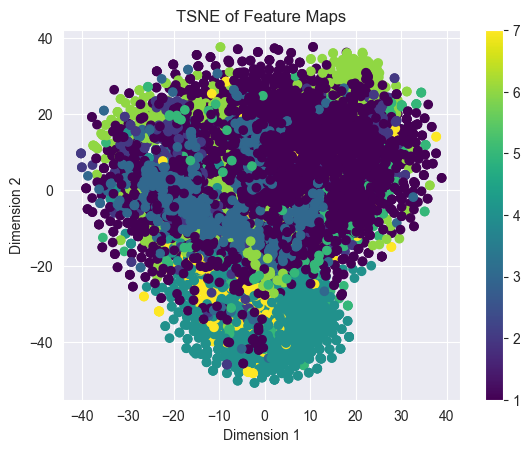

In [187]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_labels, cmap='viridis', marker='o')
plt.title('TSNE of Feature Maps')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

### Predictive Power

In [188]:
clf = LogisticRegression().fit(train_sift, train_labels)

c:\Users\mikelaucella\AppData\Local\miniconda3\envs\mlts2venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [189]:
clf.score(train_sift, train_labels)

0.9925223214285714

In [190]:
clf.score(val_sift, val_labels)

0.529113067027759

Heavily overfit this does mean though that there is a lot of informative data in the features however, we may need to cut the space down even further

In [191]:
preds = clf.predict(train_sift)
corr = preds == train_labels

In [192]:
df = pd.DataFrame({'correct': corr, 'label': train_labels})

In [193]:
df.head()

,correct,label
0,True,7
1,True,7
2,True,7
3,True,7
4,True,7


Text(0, 0.5, 'Count')

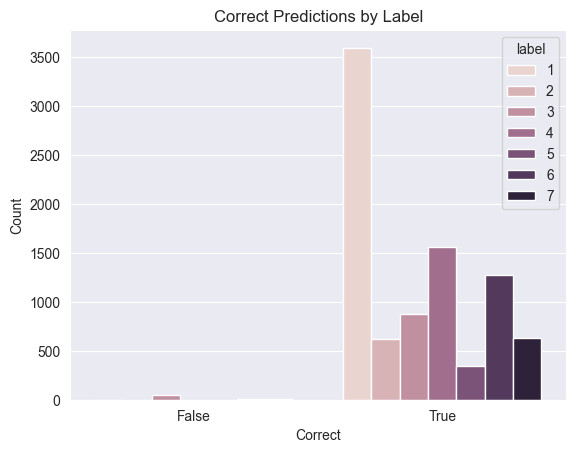

In [194]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')